In [1]:
# import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import keras
from keras.utils import to_categorical
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import rmsprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from termcolor import colored
from PIL import Image
import random
import cv2
import sys
import re
import glob
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
file_path = "./HAM10000_metadata.csv"
data_type = {0:'nv', 1:'mel', 2:'bcc'}
img_dir = './dataset/img'
pre_dir = './ham10000_images'
batch_size = 256
num_classes = 3
epochs = 100
nv_cancer_labels = np.array([
    'nv',
    'mel',
    'bcc'
])

In [3]:
df = pd.read_csv(file_path)

In [12]:
df_age1 = df[df['age'] <=60]
df_age2 = df_age1[df_age1['age'] >= 40]

In [23]:
def moveimg_age(data_type:dict, img_dir:str, pre_dir:str):
    for num in range(3):
        df_type = df_age2[df_age2['dx'] == data_type[num]]
        filename_type = df_type['image_id'].values
        for i in range(len(filename_type)):
            image_id_type = filename_type[i]
            newfile = f'{img_dir}/age/{data_type[num]}/{data_type[num]}{i}.jpg'
            shutil.copy2(f'{pre_dir}/{image_id_type}.jpg', newfile)
            img = cv2.imread(newfile)
            height = img.shape[0]
            width = img.shape[1]
            img2 = cv2.resize(img, (int(width/6), int(height/6)))
            cv2.imwrite(newfile, img2)
            
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_aug_path(data_type:str, img_dir:str):
    path = f"{img_dir}/age/{data_type}/{data_type}*"
    flist = sorted(glob.glob(path), key=numericalSort)
    return flist

def img_array(data_type:str, img_dir:str, data_num:int):
    img_array = np.zeros((data_num, 75, 100))
    img_path = get_aug_path(data_type, img_dir)
    for i in range(data_num):
        img_array[i] += np.array(((Image.open(img_path[i])).convert('L')))
    img_train, img_test = train_test_split(img_array, train_size= 0.8)
    return img_train, img_test

def dataset(dataset:int, data1:list, data2:list, data3:list):
    datasets = {0:108, 1:28}
    data = {0:data1, 1:data2, 2:data3}
    x = np.zeros((datasets[dataset]*3, 75, 100))
    for i in range(datasets[dataset]):
        for num in range(3):
            data_num = data[num][i]
            x[(3*i)+num] += data_num
    return x

def plot_history_lost(hist):
    plt.plot(hist.history['loss'], label='loss for training')
    plt.plot(hist.history['val_loss'], label='loss for validation')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()
    
def plot_history_acc(hist):
    plt.plot(hist.history['acc'], label='accuracy for validation')
    plt.plot(hist.history['val_acc'], label='accuracy for validation')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acuuracy')
    plt.ylim([0,1])
    plt.show()

In [18]:
moveimg_age(data_type, img_dir, pre_dir)

In [37]:
nv_train, nv_test = img_array(data_type[0], img_dir, 136)
mel_train, mel_test = img_array(data_type[1], img_dir, 136)
bcc_train, bcc_test = img_array(data_type[2], img_dir, 136)

/home/deepstation/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [38]:
int(136*0.8)

108

In [42]:
_x_train = dataset(0, nv_train, mel_train, bcc_train)
_x_train = _x_train.reshape((_x_train.shape[0],75,100,1))
_x_test = dataset(1, nv_test, mel_test, bcc_test)
_x_test = _x_test.reshape((_x_test.shape[0],75,100,1))
_y_train = np.array([0, 1, 2]*nv_train.shape[0])
_y_test = np.array([0, 1, 2]*nv_test.shape[0])


x_train_mean = np.mean(_x_train)
x_test_mean = np.mean(_x_test)
x_train_std = np.std(_x_train)
x_test_std = np.std(_x_test)

x_train = (_x_train - x_train_mean)/x_train_std
x_test = (_x_test - x_test_mean)/x_test_std
y_train = to_categorical(_y_train)
y_test = to_categorical(_y_test)

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [43]:
print(f'''
Dataset shape
x_train: {x_train.shape} |-> y_train: {y_train.shape},
x_test: {x_test.shape} |-> y_test: {y_test.shape},
x_validate: {x_validate.shape} |-> y_validate: {y_validate.shape}''')


Dataset shape
x_train: (291, 75, 100, 1) |-> y_train: (291, 3),
x_test: (84, 75, 100, 1) |-> y_test: (84, 3),
x_validate: (33, 75, 100, 1) |-> y_validate: (33, 3)


In [46]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (4,4), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.rmsprop()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [48]:
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[es])

model.save('nv_cancer_cnn_raw_age_gray.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 291 samples, validate on 84 samples
Epoch 1/100
291/291 [==============================] - 3s 10ms/step - loss: 1.9729 - acc: 0.3333 - val_loss: 8.0958 - val_acc: 0.3333
Epoch 2/100
291/291 [==============================] - 0s 339us/step - loss: 7.3341 - acc: 0.3402 - val_loss: 1.1183 - val_acc: 0.3333
Epoch 3/100
291/291 [==============================] - 0s 343us/step - loss: 1.1341 - acc: 0.3402 - val_loss: 1.1059 - val_acc: 0.4524
Epoch 4/100
291/291 [==============================] - 0s 342us/step - loss: 1.0718 - acc: 0.4708 - val_loss: 1.0531 - val_acc: 0.4524
Epoch 5/100
291/291 [==============================] - 0s 339us/step - loss: 0.9539 - acc: 0.5601 - val_loss: 1.2317 - val_acc: 0.4405
Epoch 6/100
291/291 [==============================] - 0s 341us/step - loss: 1.0592 - acc: 0.4914 - val_loss: 0.9947 - val_acc: 0.5357
Epoch 7/100
291/291 [==============================] - 0s 341us/step - loss: 0.8844 - acc: 0.6254 - val_loss: 1.0527 - val_acc: 0.4762
Epoch 8/100

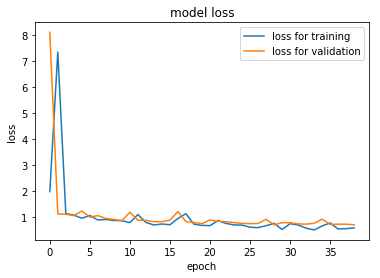

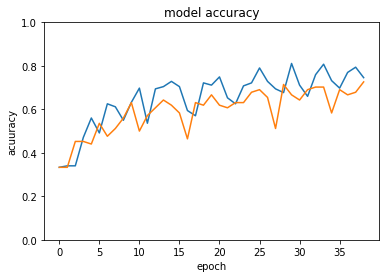

In [49]:
plot_history_lost(history)
plot_history_acc(history)

In [54]:
right = 0
mistake = 0

for j in range(30):
    index = np.zeros(100)
    for i in range(100):
        index[i] += random.randint(0,x_validate.shape[0]-1)

    for i in range(100):
        num = int(index[i])
        image = x_validate[num]
        for k in [0,1,2]:
            if y_validate[num][k] == 1:
                ans = k
        data = x_validate[num].reshape((1, 75, 100, 1))

        pred = model.predict(data, batch_size=64)
        bestnum  = 0.0
        bestclass = 0
        for n in [0,1,2]:
            if bestnum < pred[0][n]:
                bestnum = pred[0][n]
                bestclass = n

        if bestclass == ans:
            right += 1
        else:
            mistake += 1
        
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

The number of correct answers:  2175
The number of mistakes:  825
A correct answer rate:  72.5 %


In [55]:
sample_files = glob.glob('./dataset/img/sample/all/*')

right = 0
wrong = 0
for sample_file in sample_files:
    sample_img = np.array((Image.open(sample_file)).convert('L'))
#     sample_img = np.array((Image.open(sample_file)))
    norm_img = (sample_img - np.mean(sample_img))/np.std(sample_img)
    sample_data = norm_img.reshape((1, 75, 100, 1))
    pred = model.predict(sample_data)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    if sample_file[25:26] == 'n':
        ans = 0
    elif sample_file[25:26] == 'm':
        ans = 1
    else:
        ans = 2
    if ans == bestclass:
        print(f'{sample_file[25:]}:{data_type[bestclass]}')
        right += 1
    else:
        print(colored(f'{sample_file[25:]}:{data_type[bestclass]}', 'red'))
        wrong += 1
acc = right / (right + wrong) * 100
print(f'acc:{acc}%')

nv2_1.jpg:nv
nv6_1.jpg:nv
mel8_1.jpg:nv
mel1_1.jpg:mel
bcc2_1.jpg:nv
mel15_1.jpg:nv
bcc9_1.jpg:nv
bcc3_1.jpg:bcc
bcc16_1.jpg:nv
nv0_1.jpg:nv
bcc13_1.jpg:nv
bcc17_1.jpg:nv
mel3_1.jpg:mel
mel13_1.jpg:nv
nv1_1.jpg:mel
mel16_1.jpg:nv
nv4_1.jpg:nv
mel5_1.jpg:nv
bcc15_1.jpg:bcc
mel18_1.jpg:bcc
mel0_1.jpg:nv
bcc12_1.jpg:nv
bcc18_1.jpg:bcc
bcc14_1.jpg:mel
mel6_1.jpg:nv
bcc8_1.jpg:nv
nv7_1.jpg:bcc
mel4_1.jpg:nv
bcc5_1.jpg:nv
bcc6_1.jpg:nv
bcc0_1.jpg:nv
bcc1_1.jpg:mel
bcc11_1.jpg:mel
bcc10_1.jpg:nv
nv8_1.jpg:mel
mel17_1.jpg:mel
nv5_1.jpg:nv
bcc4_1.jpg:bcc
bcc7_1.jpg:nv
mel7_1.jpg:nv
mel10_1.jpg:nv
mel12_1.jpg:nv
mel9_1.jpg:nv
mel11_1.jpg:nv
nv3_1.jpg:nv
mel2_1.jpg:nv
bcc19_1.jpg:bcc
nv9_1.jpg:bcc
mel14_1.jpg:nv
acc:28.57142857142857%
